### Import Stuff

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
import scipy.constants as constants
import random
import timeit

### Particle Simulation Class

In [40]:
class particle:
    
    def __init__(self, dt, textfile, mobility, loops):
        self.time = 0. # total drifttime
        self.dt = dt # timesteps
        self.efield = self.txt_to_sa(textfile)
        self.field_strength = [0,0]
        self.mobility = mobility
        self.loops = loops
        self.result = []
        self.position = [1,1]
        self.ef = [list(x) for x in self.efield[['r','z']]]
        self.pathlist =[]
        self.diff_velocity = np.sqrt(8 * constants.k * 300 / (np.pi * 222 * constants.physical_constants['atomic mass constant'][0]))
    
    
    def txt_to_sa(self,file):
        #create a structured array from a txt file
        with open(file) as f:
            content = f.readlines()
        content = [line.split() for line in content
                  if not '%' in line]
        content = [tuple(np.float128(y) for y in x) for x in content]

        struc_array = np.array(content, np.dtype([('r',np.float128),('z',np.float128),('er',np.float128),('ez',np.float128)]))
        test = struc_array['er']**2 + struc_array['ez']**2
        print(max(np.sqrt(test))/(2.7*10**25))
        return struc_array

    
    def set_init_position(self):
        # create inital position
        random_angle = 2*np.pi*random.random()
        x_pos = 0.0781*random.random()*np.cos(random_angle)
        y_pos = x_pos*np.tan(random_angle)
        z_pos = 0.0891*random.random()
        while (z_pos < (0.0781)) and ((z_pos-0.0781)**2 + x_pos**2 + y_pos**2 > 0.0781**2):
            random_angle = 2*np.pi*random.random()
            x_pos = 0.0781*random.random()*np.cos(random_angle)
            y_pos = x_pos*np.tan(random_angle)
            z_pos = 0.0891*random.random()
        self.x = x_pos
        self.y = y_pos
        self.z = z_pos
        self.r = np.sqrt(x_pos**2 + y_pos**2)
        self.init_position = np.array([x_pos, y_pos, z_pos])
        self.position = np.array([self.r, z_pos])
    
    def update_nearest_point(self):
        # get the nearest point in the e field txt

        closest_index = distance.cdist([self.position], self.ef).argmin()
        self.nearest_point = self.ef[closest_index]
    
    def update_efield(self):
        # search the e field for position
        self.field_strength = -1*np.array([self.efield[(self.efield['r']==self.nearest_point[0]) & (self.efield['z']==self.nearest_point[1])][0][2],
                              self.efield[(self.efield['r']==self.nearest_point[0]) & (self.efield['z']==self.nearest_point[1])][0][3]])
    
    
    def set_diffusion(self):
        random_theta = 2 * np.pi * random.random()
        random_phi = 2 * np.pi * random.random()
        self.diff_vel_vec = self.diff_velocity * np.array([np.sin(random_theta)*np.cos(random_phi), np.cos(random_theta)])
        
    
    def update_drift(self):
        self.drift = self.mobility * self.field_strength * self.dt
        
    def update_position(self):
        self.position = self.position + self.drift + self.diff_vel_vec * self.dt
        self.r = self.position[0]
        self.z = self.position[1]
    
    def update_time(self):
        self.time = self.time + self.dt
    
    def append_result(self):
        self.result.append([self.init_position[0], self.init_position[1], self.init_position[2], self.time])
    
    def return_result(self):
        # most useless part of this class
        return self.result
    
    def simulate(self):
        # run the simulation
        
        
        for i in tqdm(range(self.loops)):
            self.time = 0.
            self.path = []
            self.set_init_position()
            self.path.append(self.position)
            while (self.position[1] <= 0.0889) or (self.position[0] > 0.0045):
                self.update_nearest_point()
                self.update_efield()
                self.set_diffusion()
                self.update_drift()
                self.update_position()
                self.path.append(self.position)
                self.update_time()
                if (((self.position[1] > 0.0889) and (self.position[0] > 0.0045)) or
                   (self.position[0] > 0.0781) or
                   ((self.position[1] < 0.0781) and
                   ((slef.position[1]-0.0781)**2 + self.position[0]**2 > 0.0781**2))):
                    self.time = 0
                    self.path = []
                    self.set_init_position()
                    self.path.append(self.init_position)
            self.append_result()
            self.pathlist.append(self.path)
        self.return_result()

### Simulation

In [41]:
loops = 5

sim_100ns  = particle(dt = 10**(-7), textfile='hemisphere.txt', mobility = 0.16, loops = loops)
#sim_1mus    = particle(dt = 10**(-6), textfile='hemisphere.txt', mobility = 0.16, loops = loops)
#sim_10mus  = particle(dt = 10**(-5), textfile='hemisphere.txt', mobility = 0.16, loops = loops)
#sim_100mus = particle(dt = 10**(-4), textfile='hemisphere.txt', mobility = 0.16, loops = loops)

2.8660091247112441745e-19


In [32]:
sim_100ns.simulate()
#sim_1mus.simulate()
#sim_10mus.simulate()
#sim_100mus.simulate()

100%|██████████| 5/5 [00:31<00:00,  6.37s/it]


In [45]:
222* constants.physical_constants['atomic mass constant'][0] / (2*np.pi*1.96*10**(-5)* 2.5*10**(-10))

1.1973637988478248e-11

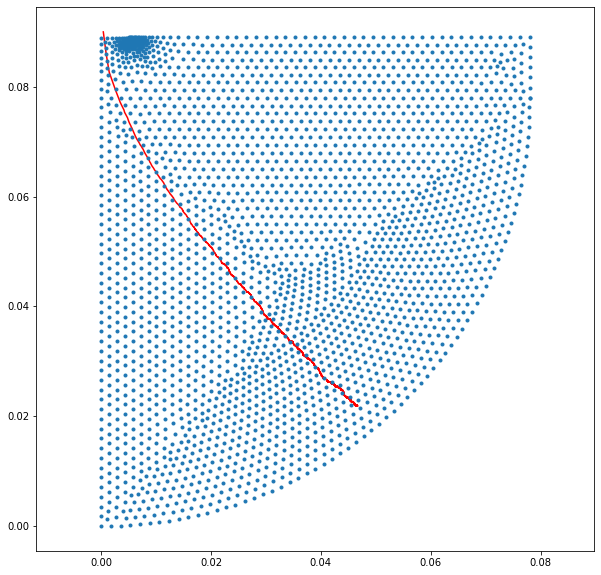

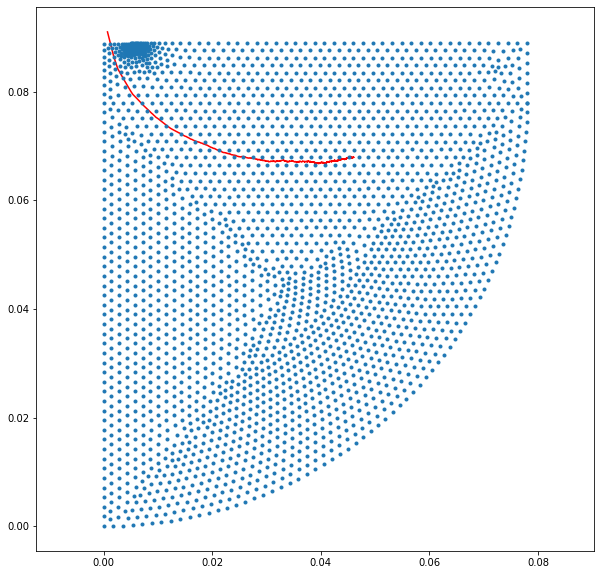

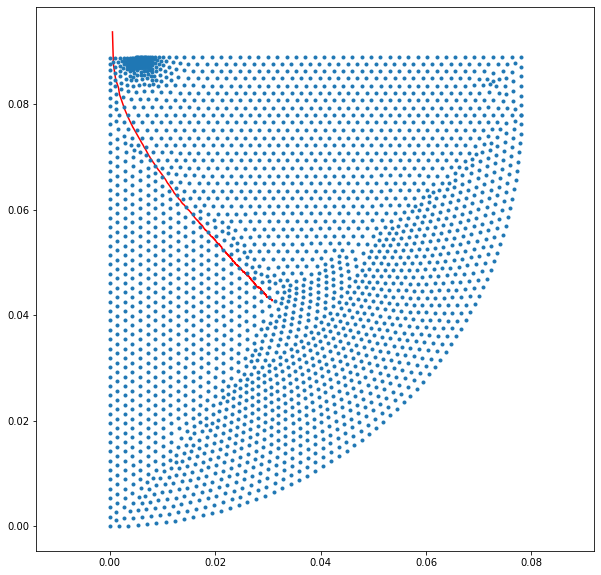

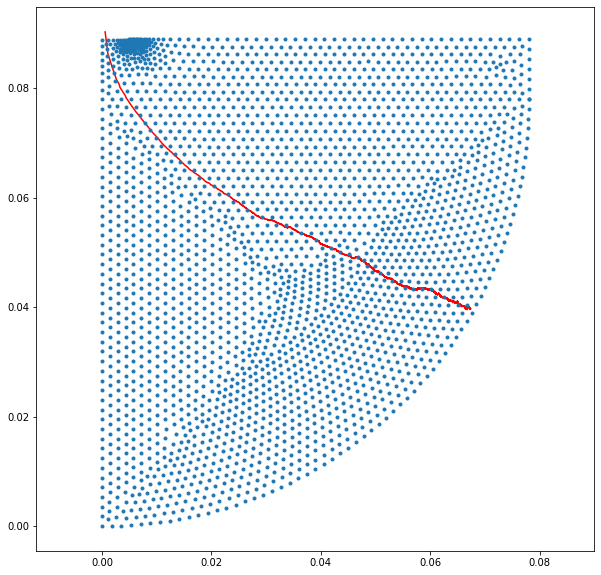

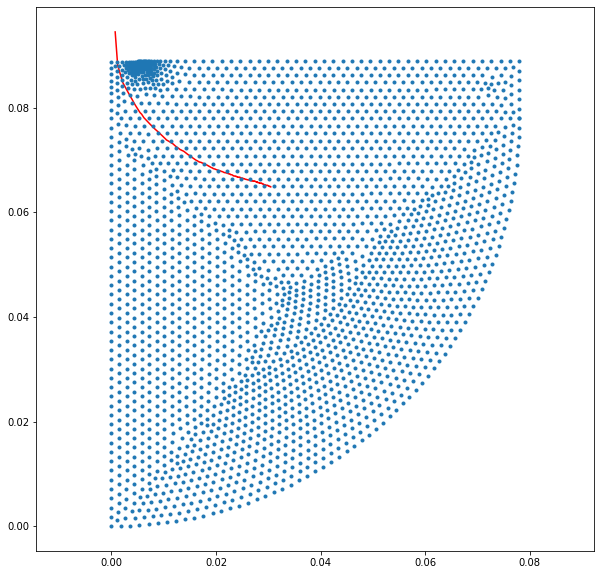

In [33]:
pathlist = sim_100ns.pathlist

efield = sim_100ns.efield
for i in pathlist:
    x_list = [j[0] for j in i]
    y_list = [j[1] for j in i]
    plt.figure(figsize=(10,10))
    plt.plot(x_list,y_list,'r')
    plt.plot(efield['r'],efield['z'],'.')
    plt.axis('equal')
    plt.show()

In [41]:
plt.plot(sim_1mus.pathlist[0])
plt.plot(x_list,y_list,'r.')
plt.plot(efield['r'],efield['z'],'.')
plt.axis('equal')
plt.show()

IndexError: list index out of range

In [63]:
j = 9
for i in range(2):
    sim_1mus   = particle(dt = 10**(-4), textfile='hemisphere.txt', mobility = 0.16, loops = loops)
    sim_1mus.simulate()
    #np.save('sim_100mus_' + str(j) + '.npy',sim_1mus.result)
    #np.save('sim_100mus_path_' + str(j) + '.npy',sim_1mus.pathlist)
    j += 1

100%|██████████| 500/500 [00:34<00:00, 14.62it/s]


In [69]:
s_1mus = np.load('sim_1mus_1.npy')
s_10mus = np.load('sim_10mus_1.npy')
s_100mus = np.load('sim_100mus_1.npy')

for i in range(2,11):
    s1 = np.load('sim_1mus_' + str(i) + '.npy')
    s10 = np.load('sim_10mus_' + str(i) + '.npy')
    s100 = np.load('sim_100mus_' + str(i) + '.npy')
    s_1mus = np.concatenate((s_1mus,s1))
    s_10mus = np.concatenate((s_10mus,s10))
    s_100mus = np.concatenate((s_100mus,s100))

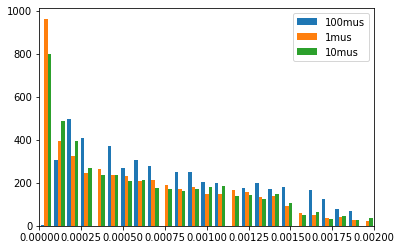

In [81]:
res_10m = [i[2] for i in s_10mus]
res_1m = [i[2] for i in s_1mus]
#res_100n = [i[2] for i in sim_100ns]
res_100m = [i[2] for i in s_100mus]

plt.hist((res_100m,res_1m,res_10m),label=('100mus','1mus','10mus'),bins=50,range=(0,0.004))
plt.xlim(0,0.002)
plt.legend()
plt.show()

In [30]:
ra = particle(dt = dt, efield = efield, mobility = mob, loops = loop,ef = ef)

In [31]:
ra.simulate()

100%|██████████| 10/10 [12:01<00:00, 72.12s/it]


In [37]:
72.12 * 5000 / 60 / 60 / 24

4.173611111111112

In [153]:
np.save('sim_test.npy',ra.result)

AttributeError: 'particle' object has no attribute 'results'

### Stuff

In [ ]:
efield = txt_to_sa('hemisphere.txt')
ef = [list(x) for x in efield[['r','z']]]
#plt.figure(figsize=(15,15))
plt.plot(efield['r'],efield['z'],'.')
plt.xlim((0,0.01))
plt.ylim((0.0875,0.09))
plt.minorticks_on()
plt.grid(which='both')
#plt.axis('equal')
plt.show()

ef = [list(x) for x in efield[['r','z']]]
print(max(list(efield['r'])))
print(max(list(efield['z'])))
print(efield['r'])

a = np.array([[0,1,2],[5,6,7]])
b = np.array([[2.4,8.0]])
np.concatenate((a,b.T),axis=1)



